<a href="https://colab.research.google.com/github/Martin09/DeepSEM/blob/master/nanowire_yield/2_nw_yield_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 - Model definition, training and saving
In this notebook we will:
1. Load and prepare our dataset.
2. Create and configure a pre-trained model from the detectron2 model zoo. 
3. Train our custom model on our dataset of labelled SEM images. 
4. Perform inference to test our model.
5. Save the model to a file for later use.


First, let's check that we are running a GPU instance of Colab:

In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime -> "Change runtime type" menu to enable GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jun  9 15:02:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

If you see a prompt above to "Change runtime type" then you are not running a GPU instance. Follow the instructions above to enable the GPU.

## Install detectron2
We will be using Facebook's [detectron2](https://github.com/facebookresearch/detectron2) library to train our model. First we need to install it and its dependencies.

In [0]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version


Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=3f2aac132f7fa2f8b7345579b2d3007712490ca2aa593bb25a45940615ceedfa
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-wav2k73q
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-wav2k73q
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [0]:
# install detectron2:
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
     |████████████████████████████████| 6.2MB 706kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200609-cp36-none-any.whl size=41028 sha256=490f325fe92156d64ed414e56a63c6b580d51581362d4d90ae2167941951e8ff
  Stored in directory: /root/.cache/pip/wheels/85/8e/6b/597adfb9e8f1617a0de4280ddfc2ee7defea6dd5c85e670424
Successfully built fvcore


In [0]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, cv2, random, json
from glob import glob
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

## Introduction
In this section, we will train an existing detectron2 model on our labelled SEM image dataset that we prepared in [Notebook 1](https://colab.research.google.com/github/Martin09/DeepSEM/blob/master/nanowire_yield/1_nw_yield_image_prep.ipynb) and labelled with [Labelbox](https://labelbox.com). We use a custom labelled nanowire detection dataset which can be downloaded [here](https://github.com/Martin09/DeepSEM/raw/master/nanowire_yield/datasets/NWs-8kMag-subdivided.zip). This dataset has been labelled with three classes: 
*   Nanowire
*   Parasitic Growth
*   Nanospade

From this, we will train a custom object detection model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note: the COCO dataset does not have any of these categories by default so we will have to perform transfer learning to get the model to detect them.

## 2.1 - Preparing our dataset

In [0]:
# Clone the DeepSEM repository
!rm -rf DeepSEM
!git clone https://github.com/Martin09/DeepSEM

# OR

# # Load from GoogleDrive
# from google.colab import drive
# drive.mount('/content/gdrive/')
# %cd "/content/gdrive/My Drive/path/to/your/data"

Cloning into 'DeepSEM'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (324/324), done.
remote: Compressing objects: 100% (303/303), done.
remote: Total 324 (delta 123), reused 143 (delta 14), pack-reused 0
Receiving objects: 100% (324/324), 57.60 MiB | 10.07 MiB/s, done.
Resolving deltas: 100% (123/123), done.


To make things easier, I have already prepared a labelled dataset and put it in a handy .zip file. Next, let's unzip this dataset to use it for training.

In [0]:
dataset_dir = './DeepSEM/nanowire_yield/datasets/NWs-8kMag-subdivided/'
!wget https://github.com/Martin09/DeepSEM/raw/master/nanowire_yield/datasets/NWs-8kMag-subdivided.zip
!unzip NWs-8kMag-subdivided.zip -d $dataset_dir
!rm NWs-8kMag-subdivided.zip

--2020-06-09 15:03:38--  https://github.com/Martin09/DeepSEM/raw/master/nanowire_yield/datasets/NWs-8kMag-subdivided.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Martin09/DeepSEM/master/nanowire_yield/datasets/NWs-8kMag-subdivided.zip [following]
--2020-06-09 15:03:39--  https://raw.githubusercontent.com/Martin09/DeepSEM/master/nanowire_yield/datasets/NWs-8kMag-subdivided.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7213125 (6.9M) [application/zip]
Saving to: ‘NWs-8kMag-subdivided.zip’

NWs-8kMag-subdivide 100%[===================>]   6.88M  16.1MB/s    in 0.4s    

2020-06-09 15:03:40 

### Calculating mean pixel intensity of dataset



The neural network learns better if we normalize the input values (pixel intensity), therefore we calculate the mean pixel value which will then be provided to the model in the configuration settings.

In [0]:
# Calcualte dataset mean pixel intensity
images_dir = './DeepSEM/nanowire_yield/datasets/NWs-8kMag-subdivided/'
images = glob(images_dir + '*.png')

min_pixel_intensity = np.infty
max_pixel_intensity = -np.infty
mean_pixel_intensity = 0
for img in images:
    im = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
    min_pixel_intensity = min([np.min(im), min_pixel_intensity])
    max_pixel_intensity = max([np.max(im), max_pixel_intensity])
    mean_pixel_intensity += np.mean(im)
mean_pixel_intensity /= len(images)

print('The min pixel intesity is: {:.2f}'.format(min_pixel_intensity))
print('The max pixel intesity is: {:.2f}'.format(max_pixel_intensity))
print('The mean pixel intesity is: {:.2f}'.format(mean_pixel_intensity))

The min pixel intesity is: 0.00
The max pixel intesity is: 255.00
The mean pixel intesity is: 58.33


### Test/train Split

Our dataset consists of our subdivided PNG images in the folder:
```
./DeepSEM/nanowire_yield/datasets/NWs-8kMag-subdivided/
```

Along with our bounding box labels in the form of a labelbox JSON export file located at:
```
'./DeepSEM/nanowire_yield/datasets/export-2020-05-26T15_27_19.519Z.json'
```

Next, we will create a helper function to divide the exported JSON file into two smaller files: a training set and a test set.

In [0]:
# Takes a labelbox exported JSON file and randomly splits it into two other JSON files:
# one for testing and one for validation. Assumes test set should be ~10% of all examples.
def test_train_split(json_file, t_out = 'train.json', v_out = 'val.json'):
    
    # Load Labelbox export file
    with open(json_file) as f:
        dat = json.load(f)

     # Remove empty entries   
    dat = [d for d in dat if d["Label"] != {}]  
    
    # Choose some indices at random for the test set, the rest are for training
    i_test = np.random.choice(len(dat), int(len(dat)*0.1))
    i_train = list(set(list(range(len(dat))))-set(i_test))

    # Split the dataset according to the indices
    dat_train = [dat[i] for i in i_train]
    dat_test = [dat[i] for i in i_test]

    # Write the train.json and val.json files
    with open(t_out, 'w') as fout:
        json.dump(dat_train, fout)
    with open(v_out, 'w') as fout:
        json.dump(dat_test, fout)      
    
    print("Exported {} training images and {} test images!".format(len(i_train),len(i_test)))

In [0]:
json_file = './DeepSEM/nanowire_yield/datasets/NWs-8kMag-subdivided/export-2020-05-26T15_27_19.519Z.json'
train_out = './DeepSEM/nanowire_yield/datasets/NWs-8kMag-subdivided/nw_yield_train.json'
test_out = './DeepSEM/nanowire_yield/datasets/NWs-8kMag-subdivided/nw_yield_test.json'
test_train_split(json_file, train_out, test_out)

Exported 31 training images and 3 test images!


Register the datasets to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in a custom format, therefore we have to write a function to parse it and convert it to detectron2's standard format. See the tutorial for more details.


In [0]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

# Takes in dataset JSON file and returns a list of dicts in detectron2 format for training
def get_nw_dicts_from_labelbox(json_file):
    category_dict = {'nw':0, 'parasitic':1, 'nanospade':2}

    with open(images_dir + json_file) as f:
        img_anns = json.load(f)

    dataset_dicts = []
    for idx,img in enumerate(img_anns):
        filename = images_dir+'/'+img['External ID']
        height, width = cv2.imread(filename).shape[:2]

        record = {}
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []
        for anno in img['Label']['objects']:
            bb = anno['bbox']

            obj = {
                "bbox": [bb['left'], bb['top'], bb['width'], bb['height']],
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": category_dict[anno['value']],
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

Now we register the train and test datasets in detectron2:

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.clear()

for d in ["train", "test"]:
    DatasetCatalog.register("nw_yield_" + d, lambda d=d: get_nw_dicts_from_labelbox("nw_yield_" + d + ".json"))
    MetadataCatalog.get("nw_yield_" + d).set(thing_classes=["nw","parasitic","nanospade"])
nanowire_metadata = MetadataCatalog.get("nw_yield_train")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



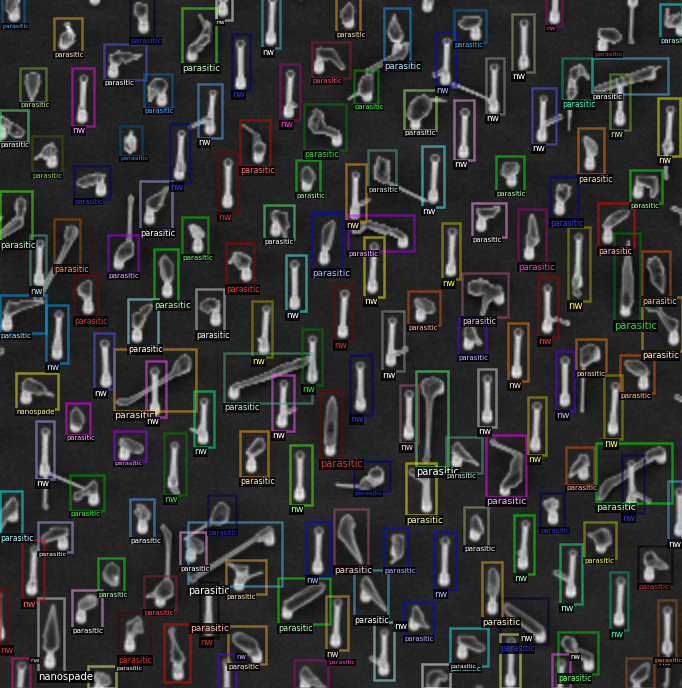

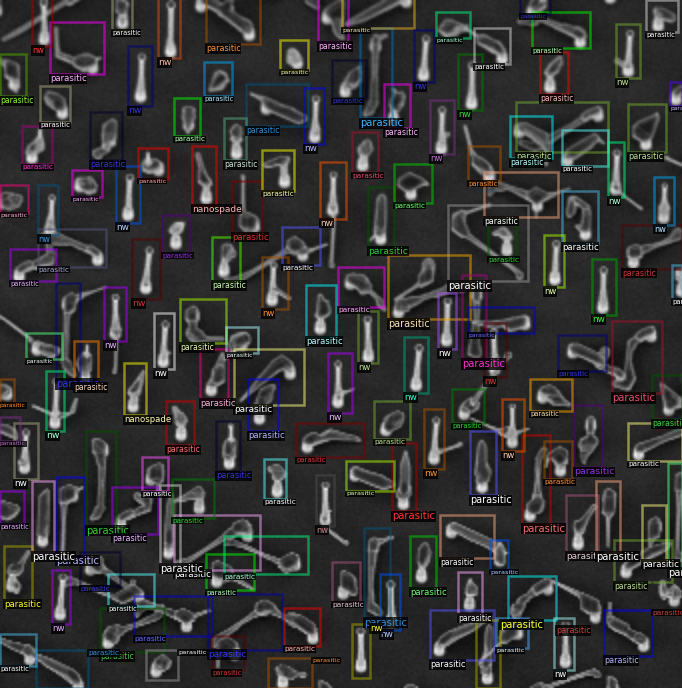

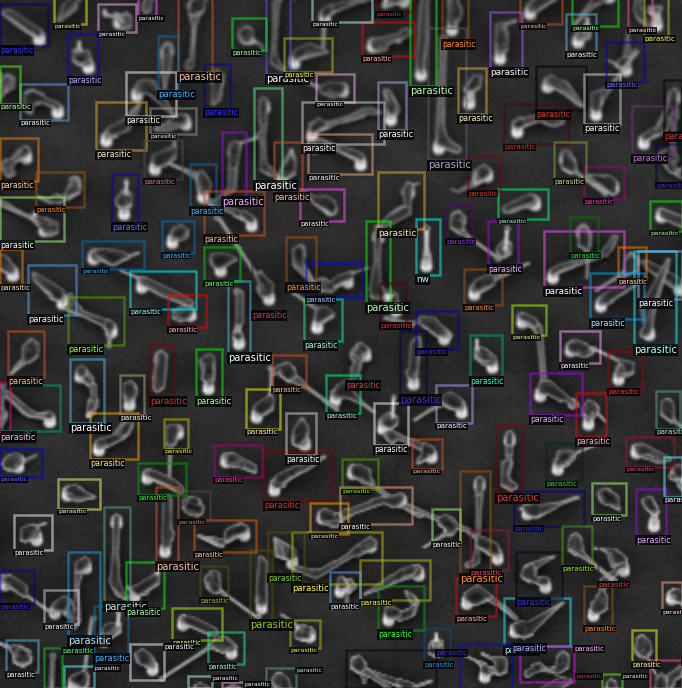

In [0]:
dataset_dicts = get_nw_dicts_from_labelbox("nw_yield_train.json")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])

    visualizer = Visualizer(img[:, :, ::-1], metadata=nanowire_metadata, scale=2.0)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## 2.2 - Model definition

Now, we will load a COCO-pretrained R50-FPN Mask R-CNN model from the [detectron2 model zoo](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md). We will then modify its configuration settings in order to adapt it for transfer learning on our SEM dataset.

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
output_dir = './DeepSEM/nanowire_yield/output/' + timestamp

cfg = get_cfg()
cfg.OUTPUT_DIR = output_dir
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("nw_yield_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 16
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.01  # learning rate
cfg.SOLVER.MAX_ITER = 100  # 100 is decent for proof of concept, but use 10k+ for the final model
cfg.SOLVER.CHECKPOINT_PERIOD = 10000  # Save a checkpoint after every this number of iterations

# Learning rate warmup and decay
cfg.SOLVER.WARMUP_FACTOR = 1/1000.  # Learning starts at BASE_LR * WU_FACTOR
cfg.SOLVER.WARMUP_ITERS = 1000  # Number of iterations for warm-up phase
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.GAMMA = 0.5
# cfg.SOLVER.STEPS = (100,200,300,)  # List of iteration numbers at which to decrease learning rate by factor GAMMA.
cfg.SOLVER.STEPS = tuple(range(0,cfg.SOLVER.MAX_ITER,1000))

# Validation set
cfg.TEST.EVAL_PERIOD = 0
cfg.TEST.DETECTIONS_PER_IMAGE = 1000

# Don't scale the input images
cfg.INPUT.MIN_SIZE_TRAIN = (0,)  # Keep these data types or might run into issues during inference when loading config file
cfg.INPUT.MAX_SIZE_TRAIN = 99999  # Keep these data types or might run into issues during inference when loading config file

cfg.MODEL.RPN.IN_FEATURES = ['p2', 'p2', 'p3', 'p4', 'p5', 'p6']
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.25, 0.5, 1.0, 2.0, 4.0, 8.0]]
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[4], [8], [16], [32], [64], [128]]
cfg.MODEL.PIXEL_MEAN = [58.33, 58.33, 58.33] 
cfg.MODEL.PIXEL_STD = [1.0, 1.0, 1.0]
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4096
cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION = 0.5
cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.5] # Intersection over union threshold
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # We have three classification classes 
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 4000
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 4000

We can start up tensorboard to monitor training progress in realtime.

In [0]:
# Look at training curves in tensorboard:
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir ./DeepSEM/nanowire_yield/output

<IPython.core.display.Javascript object>

## 2.3 - Training
It takes ~3 minutes to train 100 iterations on Colab Pro's Tesla P100 GPUs and a bit longer on Colab's free Tesla K80 GPUs.

In [0]:
# Start training
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/09 15:03:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:15, 10.5MB/s]                           
Unable to load 'proposal_generator.anchor_generator.cell_anchors.0' to the model due to incompatible shapes: (3, 4) in the checkpoint but (6, 4) in the model!
Unable to load 'proposal_generator.anchor_generator.cell_anchors.1' to the model due to incompatible shapes: (3, 4) in the checkpoint but (6, 4) in the model!
Unable to load 'proposal_generator.anchor_generator.cell_anchors.2' to the model due to incompatible shapes: (3, 4) in the checkpoint but (6, 4) in the model!
Unable to load 'proposal_generator.anchor_generator.cell_anchors.3' to the model due to incompatible shapes: (3, 4) in the checkpoint but (6, 4) in the model!
Unable to load 'proposal_generator.anchor_generator.cell_anchors.4' to the model due to incompatible shapes: (3, 4) in the checkpoint but (6, 4) in the model!
Unable to load 'proposal_generator.rpn_head.objectness_logits.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in t

[06/09 15:04:23 d2.engine.train_loop]: Starting training from iteration 0
[06/09 15:05:03 d2.utils.events]:  eta: 0:02:36  iter: 19  total_loss: 1.823  loss_cls: 0.564  loss_box_reg: 0.024  loss_rpn_cls: 0.656  loss_rpn_loc: 0.578  time: 1.9331  data_time: 0.1490  lr: 0.000100  max_mem: 8815M
[06/09 15:05:42 d2.utils.events]:  eta: 0:01:58  iter: 39  total_loss: 1.252  loss_cls: 0.226  loss_box_reg: 0.051  loss_rpn_cls: 0.610  loss_rpn_loc: 0.358  time: 1.9362  data_time: 0.0736  lr: 0.000200  max_mem: 8815M
[06/09 15:06:22 d2.utils.events]:  eta: 0:01:19  iter: 59  total_loss: 1.261  loss_cls: 0.240  loss_box_reg: 0.142  loss_rpn_cls: 0.554  loss_rpn_loc: 0.325  time: 1.9574  data_time: 0.0929  lr: 0.000300  max_mem: 8815M
[06/09 15:07:01 d2.utils.events]:  eta: 0:00:41  iter: 79  total_loss: 1.184  loss_cls: 0.237  loss_box_reg: 0.226  loss_rpn_cls: 0.412  loss_rpn_loc: 0.311  time: 1.9613  data_time: 0.0987  lr: 0.000400  max_mem: 8815M
[06/09 15:07:41 d2.utils.events]:  eta: 0:00:0

Hopefully, during training you should start to see the `total_loss` decreasing over time as the model learns. Initially, the learning rate (`lr`) will increase during the warm-up stage for 1000 iterations. After which it will be halved every 1000 iterations until the end of training. These settings can all be changed in the config (`cgf.XX = X`) definitions above. As a proof of concept, I have set `cfg.SOLVER.MAX_ITER=100` but you should increase this to 1000 or even 10000 to achieve the best performance.

## 2.4 - Inference with a trained model
Now, let's run inference with the trained model on the test dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # Set the testing score threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2     # Non-max supression (ie: bounding box overlap) threshold
cfg.DATASETS.TEST = ("nw_yield_test", )
cfg.TEST.DETECTIONS_PER_IMAGE = 200
cfg.INPUT.MIN_SIZE_TEST = 0
cfg.INPUT.MAX_SIZE_TEST = 99999
predictor = DefaultPredictor(cfg)

Then, we randomly select a few samples to visualize the prediction results.

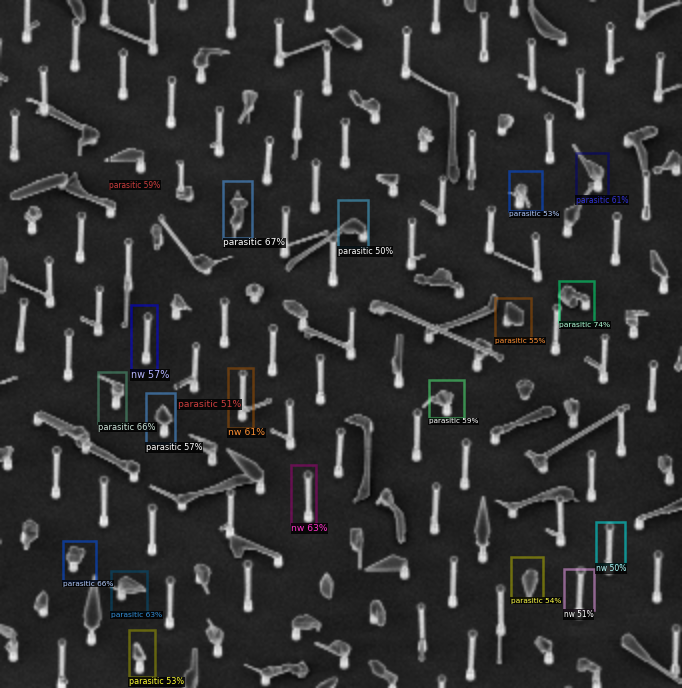

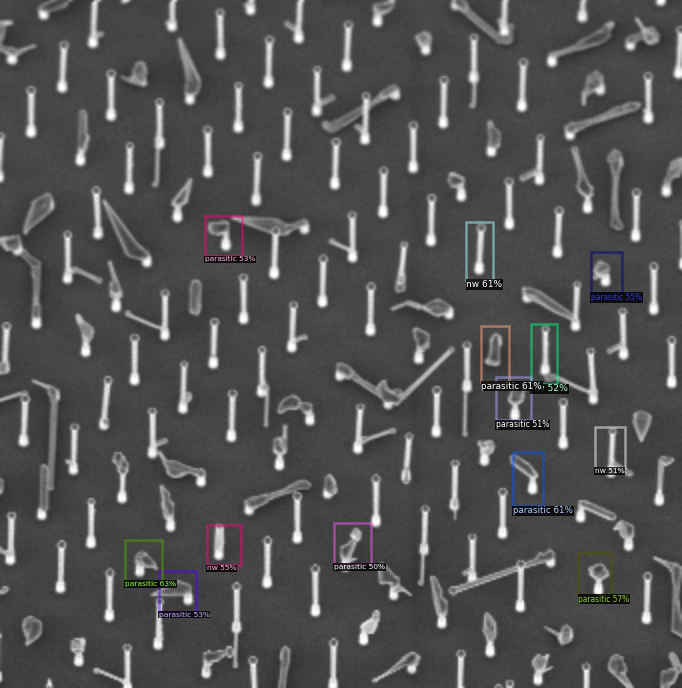

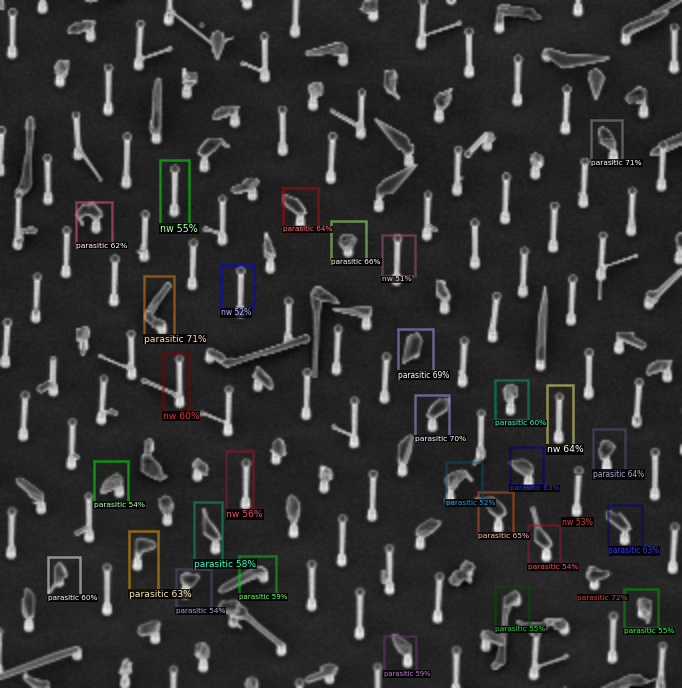

In [0]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_nw_dicts_from_labelbox("nw_yield_test.json")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=nanowire_metadata, 
                   scale=2.0, 
                  #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

Even with just 100 training iterations you should start to see a few objects get correctly labelled in this dataset. If not, something is wrong. As you train for longer, the training loss should approach 0.1 and the predictions will get more accurate. At >10k training iterations the model should achieve near-perfect bounding box and classification accuracy.

In [0]:
# # Check the outputs of the neural network manually:
# outputs["instances"].pred_boxes
# outputs["instances"].scores
# outputs["instances"].pred_classes

We can also evaluate its performance using AP metric implemented in COCO API.

In [0]:
# ## Not working yet, probably don't have dataset in proper COCO format
# from detectron2.evaluation import COCOEvaluator, inference_on_dataset
# from detectron2.data import build_detection_test_loader
# evaluator = COCOEvaluator("nw_yield_train", cfg, False)#, output_dir="./output/")
# val_loader = build_detection_test_loader(cfg, "nw_yield_train")
# inference_on_dataset(trainer.model, val_loader, evaluator)
# # another equivalent way is to use trainer.test

## 2.5 - Saving the trained model
Now let's save our final model for safe keeping. We will use this model in the next notebook for inference on a full-scale SEM image.

In [0]:
weights_source = cfg.OUTPUT_DIR + '/model_final.pth'
model_name = 'nw_yield_it'+str(trainer.iter)+'_loss0.93.yaml'
model_dest = './DeepSEM/nanowire_yield/trained_models/' + model_name

# Move weights file to "trained_models" folder and update the config file accordingly
weights_dest = model_dest[:-5] + '.pth'
!cp $weights_source $weights_dest
cfg.MODEL.WEIGHTS = weights_dest

# Save the config file alongside the weights file
confi_dest = model_dest
with open(confi_dest, "w") as text_file:
    text_file.write(cfg.dump())

## A final note on overfitting

In this example we are only monitoring the training loss as a function of iterations. This has the disadvantage that we do not know if our model is over-fitting to our training set. In this simple application we don't worry about overfitting too much, especially as the model seems to perform well on the test set after training. However, to achieve the best possible performance, we should create a small third dataset called a validation set with which we periodically estimate the performance of the model during training. Training should then be stopped when validation loss stops decreasing to prevent overfitting on the training set.

Next, in [Notebook 3](https://colab.research.google.com/github/Martin09/DeepSEM/blob/master/nanowire_yield/3_nw_yield_yield_analysis.ipynb), let's see how we can apply our trained model to full-scale SEM images and estimate nanowire growth yield!